In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import torchvision
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score,recall_score,f1_score
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
dataset = load_dataset("uoft-cs/cifar10")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = transform(item["img"])
        label = item["label"]
        return image, label

In [3]:
train_dataset = CustomDataset(dataset["train"])
test_dataset = CustomDataset(dataset["test"])
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size =32, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7019608..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.9529412].


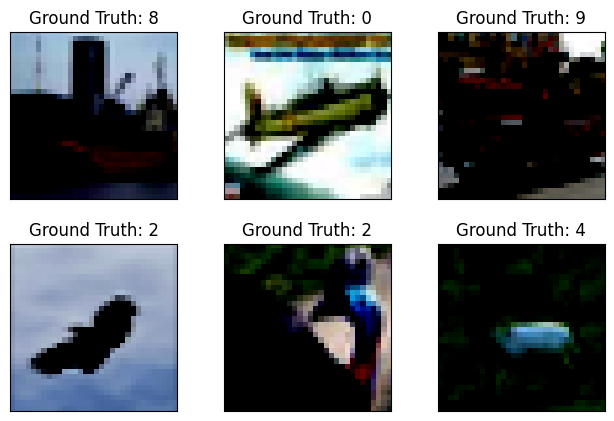

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i].permute(1, 2, 0)) 
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [5]:
class main(nn.Module):
    def __init__(self,output_class = 10):
        super(main, self).__init__()
        self.conv_nn = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=1),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=2,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128,256,kernel_size=2,stride=1),
            nn.ReLU(),
            nn.Conv2d(256,512,kernel_size=2,stride=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_nn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*6*6,256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, output_class),
        )
    def forward(self,x):
        x = self.conv_nn(x)
        x = self.fc_nn(x)
        return x

In [6]:
model = main(output_class = 10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.8, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion = nn.CrossEntropyLoss()
loss_values = []

In [7]:
def train(model,train_loader,optimizer,criterion):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss_value = criterion(output,label)
        loss_values.append(loss_value.item())
        loss_value.backward()
        optimizer.step()

        if batch_idx%100 == 0:
            print(f'Batch {batch_idx+1}, Loss: {loss_value.item()}')
def test(model,test_loader,criterion):
    model.eval()
    total_correct = 0
    test_loss = 0
    total = 0

    all_preds = []
    all_labels = []


    with torch.no_grad():
        for batch_idx, (image,label) in enumerate(test_loader):
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            loss_value = criterion(output,label)
            test_loss += loss_value.item()
            _,predicted = torch.max(output,1)
            total_correct += (predicted == label).sum().item()
            total += label.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
        accuracy = total_correct / total
        precision = precision_score(all_labels, all_preds, average="weighted")
        recall = recall_score(all_labels, all_preds, average="weighted")
        f1 = f1_score(all_labels, all_preds, average="weighted")
        print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"\nTest Loss: {test_loss/total:.4f}, Accuracy: {100 * accuracy:.2f}%\n")
        


In [8]:
epoch = 15
for e in range(epoch):
    print(f"\nEpoch {e+1}/{epoch}")
    train(model, train_loader, optimizer,criterion)
    test(model, test_loader,criterion)


Epoch 1/15
Batch 1, Loss: 2.310136079788208
Batch 101, Loss: 2.3023428916931152
Batch 201, Loss: 2.2656285762786865
Batch 301, Loss: 2.001389741897583
Batch 401, Loss: 1.7522650957107544
Batch 501, Loss: 2.105293035507202
Batch 601, Loss: 1.7317795753479004
Batch 701, Loss: 1.9810905456542969
Batch 801, Loss: 1.873608112335205
Batch 901, Loss: 1.601924180984497
Batch 1001, Loss: 1.871880292892456
Batch 1101, Loss: 1.3841452598571777
Batch 1201, Loss: 1.7908658981323242
Batch 1301, Loss: 1.4202477931976318
Batch 1401, Loss: 1.4321178197860718
Batch 1501, Loss: 1.3549010753631592

Precision: 0.4786, Recall: 0.4525, F1-score: 0.4438

Test Loss: 0.0493, Accuracy: 45.25%


Epoch 2/15
Batch 1, Loss: 1.4954705238342285
Batch 101, Loss: 1.2998132705688477
Batch 201, Loss: 1.7223987579345703
Batch 301, Loss: 1.4482078552246094
Batch 401, Loss: 1.3695576190948486
Batch 501, Loss: 1.4708836078643799
Batch 601, Loss: 1.2766742706298828
Batch 701, Loss: 1.6179267168045044
Batch 801, Loss: 1.342427

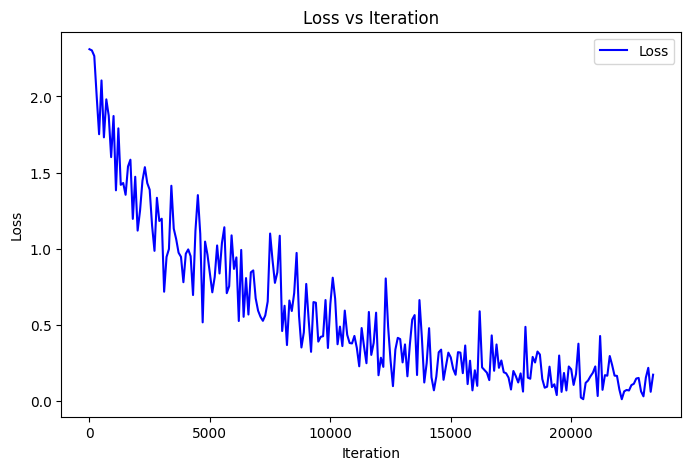

In [9]:
iterations = list(range(len(loss_values)))
plt.figure(figsize=(8, 5))
plt.plot(iterations[::100], loss_values[::100], label="Loss", color='b')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.legend()
plt.show()